In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Imports and Paths

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import copy
import sklearn
import rastermap
import pandas as pd

import tensorly as tl
import tensorly.decomposition

In [3]:
dir_github        = Path(r'/n/data1/hms/neurobio/sabatini/gyu/github_clone').resolve()

dir_analysisFiles = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data').resolve()

## Directory with F.npy, stat.npy etc.
dir_s2p         = Path(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/suite2p/plane0').resolve()
# dir_s2p         = Path(r'C:\Users\Rich Hakim\Downloads\F.npy').resolve()

## Path of iscell. Can be from neural net output (iscell_NN)
path_iscell = dir_analysisFiles / 'iscell_NN_tqm.npy'

## Path of tqm (trace quality metrics). Used to get dFoF parameters
path_tqm = dir_analysisFiles / 'trace_quality.pkl'


dir_save       =  copy.copy(dir_analysisFiles)
path_save = dir_save / 'weights_day0'
# path_save = dir_save / 'weights_day0_PC2'

In [4]:
import sys
sys.path.append(str(dir_github))

%load_ext autoreload
%autoreload 2

from bnpm import torch_helpers, file_helpers, timeSeries, ca2p_preprocessing, welford_moving_2D, linear_regression, similarity

%load_ext autoreload
%autoreload 2
from Big_Ugly_ROI_Tracker.multiEps.multiEps_modules import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def get_highest_evr_var(data, factors,  hits):
    evrs = np.zeros(factors.shape[0])
    for i, factor in enumerate(factors):
        _,_,_,evr_total = similarity.orthogonalize(data, factor)
        evrs[i] = evr_total
    evrs[np.logical_not(hits)] = 0
    highest_evr_ind = np.argsort(evrs)[-1]
    return highest_evr_ind, factors[highest_evr_ind,:], evrs

def orthogonalize_simple(data, factor):
    proj_vec = similarity.proj(data, factor)[0]
    return (np.squeeze(data) - np.squeeze(proj_vec))

In [6]:
DEVICE = torch_helpers.set_device(use_GPU=True)

devices available: [_CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=22698MB, multi_processor_count=72)]
Using device: 'cuda:0': _CudaDeviceProperties(name='Quadro RTX 6000', major=7, minor=5, total_memory=22698MB, multi_processor_count=72)


In [7]:
iscell = np.load(path_iscell)
# spks = np.load(path_spks)

In [8]:
tqm = file_helpers.pickle_load(path_tqm)
dFoF_params = tqm['dFoF_params']

In [9]:
## == IMPORT DATA ==
F = np.load(dir_s2p / 'F.npy') # masks multiplied by data
Fneu = np.load(dir_s2p / 'Fneu.npy') # estimated neuropil signal (Fns = F - Fneu; Fo = ptile(Fns, 30); dFoF=Fns-Fo/Fo)
# iscell = np.load(dir_s2p/'iscell.npy') # probability and bool of each roi
ops = np.load(dir_s2p / 'ops.npy', allow_pickle=True) # parameters for the suite2p
spks_s2p = np.load(dir_s2p / 'spks.npy') # blind deconvolution
stat = np.load(dir_s2p / 'stat.npy', allow_pickle=True) # statistics for individual neurons 

num_frames_S2p = F.shape[1]
Fs = ops[()]['fs']

In [10]:
# # Oopsie!
# # Mouse g2FB: delete 43000 - 50000 frames
# F = np.delete(F, range(43000,50000), axis=1)
# Fneu = np.delete(Fneu, range(43000,50000), axis=1)

In [11]:
Fneu.shape

(3608, 108000)

In [12]:
frame_height = ops[()]['meanImg'].shape[0]
frame_width = ops[()]['meanImg'].shape[1]

sf = import_and_convert_to_CellReg_spatialFootprints([dir_s2p / 'stat.npy'], frame_height=frame_height, frame_width=frame_width, dtype=np.float32)[0]

In [13]:
F_toUse = F[iscell]
Fneu_toUse = Fneu[iscell]

# Prepare dFoF

In [14]:
win_smooth = 4
kernel_smoothing = np.zeros(win_smooth*2)
kernel_smoothing[win_smooth:] = 1
kernel_smoothing /= kernel_smoothing.sum()

In [15]:
# Pipeline for the NMF Strategy 
# Smooth F
F_smooth = timeSeries.convolve_along_axis(
    F_toUse,
    kernel=kernel_smoothing,
    axis=1,mode='same',
    multicore_pref=True,
    verbose=True
).astype(np.float32)

# dFoF with reduced percentile for baseline
channelOffset_correction = 500
percentile_baseline = 5
neuropil_fraction=0.7

dFoF , dF , F_neuSub , F_baseline = ca2p_preprocessing.make_dFoF(
    F=F_smooth + channelOffset_correction,
    Fneu=Fneu_toUse + channelOffset_correction,
    neuropil_fraction=neuropil_fraction,
    percentile_baseline=percentile_baseline,
    multicore_pref=True,
    verbose=True
)
# Threshold for nonnegativity
dFoF_z = dFoF / np.std(dFoF,axis=1,keepdims=True)

100%|██████████| 846/846 [00:00<00:00, 442938.61it/s]


ThreadPool elapsed time : 0.23 s. Now unpacking list into array.
Calculated convolution. Total elapsed time: 0.51 seconds
Calculated dFoF. Total elapsed time: 10.24 seconds


In [16]:
# Test out rolling subtraction of the 10th percentile of the daa to remove microscope movement artifacts

ptile = 10
window = int(Fs*60*1)

dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_pd(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile = dFoF - timeSeries.rolling_percentile_rq_multicore(dFoF, ptile=ptile, window=window)
# dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0, a_max=None)

In [17]:
# Clip to remove any remnent artifact & make data non-negative
dFoF_sub_ptile_clipped = np.clip(dFoF_sub_ptile, a_min=0.2, a_max=None)

### Look at rastermap

In [18]:
import rastermap

In [19]:
rmap = rastermap.Rastermap(
    n_components=1,
    n_X=40,
    nPC=200,
    init='pca',
    alpha=1.0,
    K=1.0,
    mode='basic',
    verbose=True,
    annealing=True,
    constraints=2,
)

In [20]:
# rmap.fit(dFoF_sub_ptile)
rmap.fit(dFoF_sub_ptile_clipped)
# rmap.fit(scipy.stats.zscore(dFoF))

nmin 200
0.32591772079467773
5.8707520961761475
6.2207560539245605
6.223097801208496
(38, 40)
(70,)
1.0
time; iteration;  explained PC variance
0.20s     0        0.1561      2
0.22s    10        0.2908      4
0.24s    20        0.3367      8
0.26s    30        0.4277      18
0.27s    40        0.4882      28
0.29s    50        0.5498      38
0.31s    60        0.5507      38
0.32s   final      0.5507
0.32s upsampled    0.5507


<IPython.core.display.Javascript object>


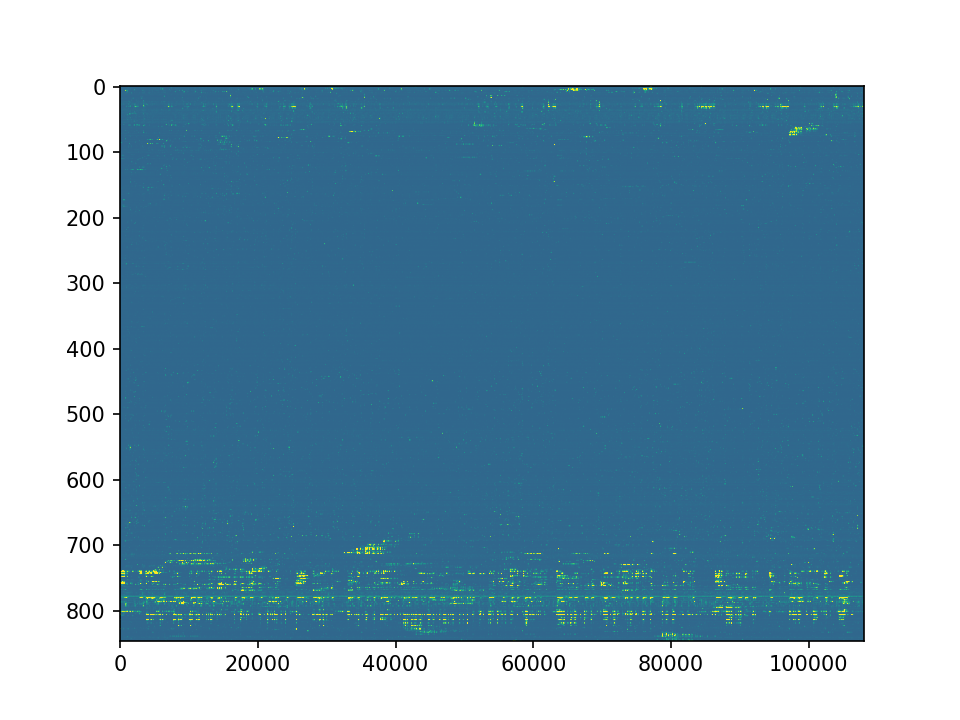

In [21]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
# plt.imshow(np.clip(scipy.stats.zscore(dFoF_sub_ptile, axis=1), -1,1)[rmap.isort], aspect='auto', vmax=1)
plt.imshow(dFoF_sub_ptile_clipped[rmap.isort], aspect='auto', vmin=-0.2, vmax=1)
# plt.imshow(scipy.stats.zscore(dFoF)[rmap.isort], aspect='auto', vmin=-0.1, vmax=1)

# Run SPCA

In [22]:
# neural_data_toUse =dFoF / np.std(dFoF,axis=1,keepdims=True)
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))[:,indices_cropped]
neural_data_toUse = (dFoF_sub_ptile_clipped / np.std(dFoF_sub_ptile_clipped,axis=1,keepdims=True))

In [23]:
# neural_data_toUse = (dFoF_sub_ptile / np.std(dFoF_sub_ptile,axis=1,keepdims=True))
# neural_data_toUse = similarity.orthogonalize(neural_data_toUse.T, traces_toOrth)[0].T

# neural_data_toUse = np.clip(neural_data_toUse, a_min=0, a_max=None)

#### Orthogonalize avgVector out


In [24]:
import bnpm.similarity

In [25]:
# avgVector in neural_data_toUse space is supposed to be all-ones vector, but just to make sure...
neural_data_toUse_ms = neural_data_toUse - neural_data_toUse.mean(1)[:,np.newaxis]
avgVector = neural_data_toUse.std(1)[np.newaxis,:]
orthogonal_trace_ms = ((avgVector @ neural_data_toUse_ms) / (avgVector @ avgVector.T));

In [26]:
## Orthogonalize avgVector activity across time out
neural_data_toUse_ortho = bnpm.similarity.pairwise_orthogonalization_torch(neural_data_toUse_ms.T, orthogonal_trace_ms.squeeze(),center=True)[0].T
neural_data_toUse_ortho_centered = neural_data_toUse_ortho - neural_data_toUse_ortho.mean(1, keepdims=True)

<IPython.core.display.Javascript object>


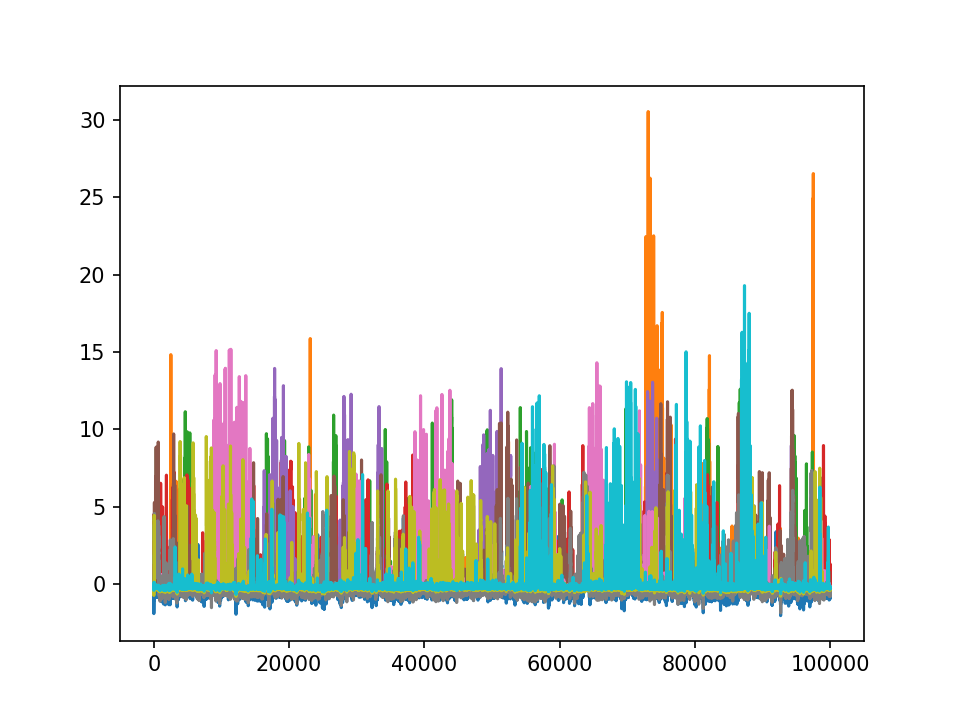

In [27]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_ortho[ii,:100000])

In [28]:
# Roll a dice and wish for luck
rank = 10

In [30]:
# Initialization method: np.linalg.svd(X, full_matrices=False)
SPCA = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=None,
                                             V_init=None,
                                             verbose=True,
                                             random_state=None)

factors_SPCA = SPCA.fit_transform(neural_data_toUse_ortho_centered.T)

[dict_learning] .

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    1.4s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


In [ ]:
# Initialization method: Manual PCA
PCA = sklearn.decomposition.PCA(n_components=rank,
                               copy=True,
                               whiten=False,
                               svd_solver='auto',
                               tol=0.0,
                               iterated_power='auto',
                               n_oversamples=10,
                               power_iteration_normalizer='auto',
                               random_state=None)

U_init = PCA.fit_transform(neural_data_toUse_ortho_centered.T)
V_init = PCA.components_

SPCA = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=U_init,
                                             V_init=V_init,
                                             verbose=True,
                                             random_state=None)

factors_SPCA = SPCA.fit_transform(neural_data_toUse_ortho_centered.T)

In [31]:
factors_neuron_SPCA = SPCA.components_.T
factors_temporal_SPCA = factors_SPCA.T

# Run Regression

In [32]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])

## z-score SPCA  temporal factors
factors_temporal_SPCA_zscore = scipy.stats.zscore(factors_temporal_SPCA[:,indices_to_use],axis=1)

In [33]:
## z-score neural data ORTHOGONAL to avgVector
neural_data_toUse_zscore = welford_moving_2D.make_rollingZScore(np.array(neural_data_toUse_ortho).T, win_roll=int(Fs*60*10)).T
neural_data_toUse_zscore = neural_data_toUse_zscore[:,indices_to_use]

100%|██████████| 108000/108000 [00:14<00:00, 7221.70it/s]
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: divide by zero encountered in divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)
/n/data1/hms/neurobio/sabatini/gyu/github_clone/basic_neural_processing_modules/bnpm/welford_moving_2D.py:142: RuntimeWarning: invalid value encountered in divide
  X_zscore_roll = (list_of_values - X_mean_rolling)/np.sqrt(X_var_rolling)


<IPython.core.display.Javascript object>


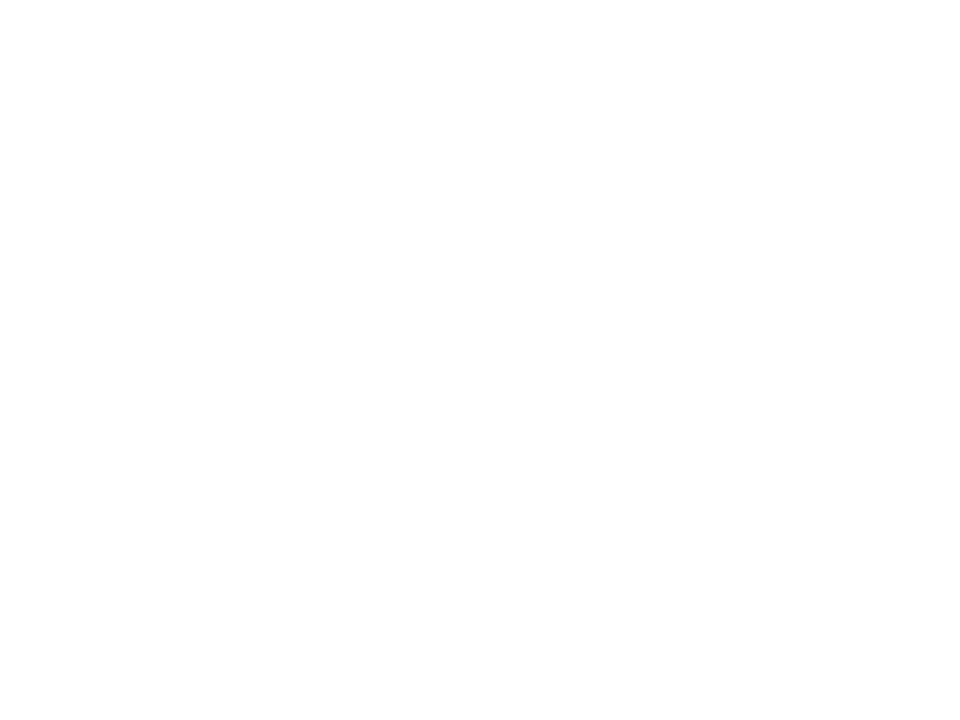

In [34]:
plt.figure()
for ii in range(10):
    plt.plot(neural_data_toUse_zscore[ii,:100000])

In [35]:
neural_data_toUse_zscore = np.nan_to_num(neural_data_toUse_zscore, nan=0)

In [36]:
neural_data_toUse_zscore.shape

(846, 90000)

<IPython.core.display.Javascript object>


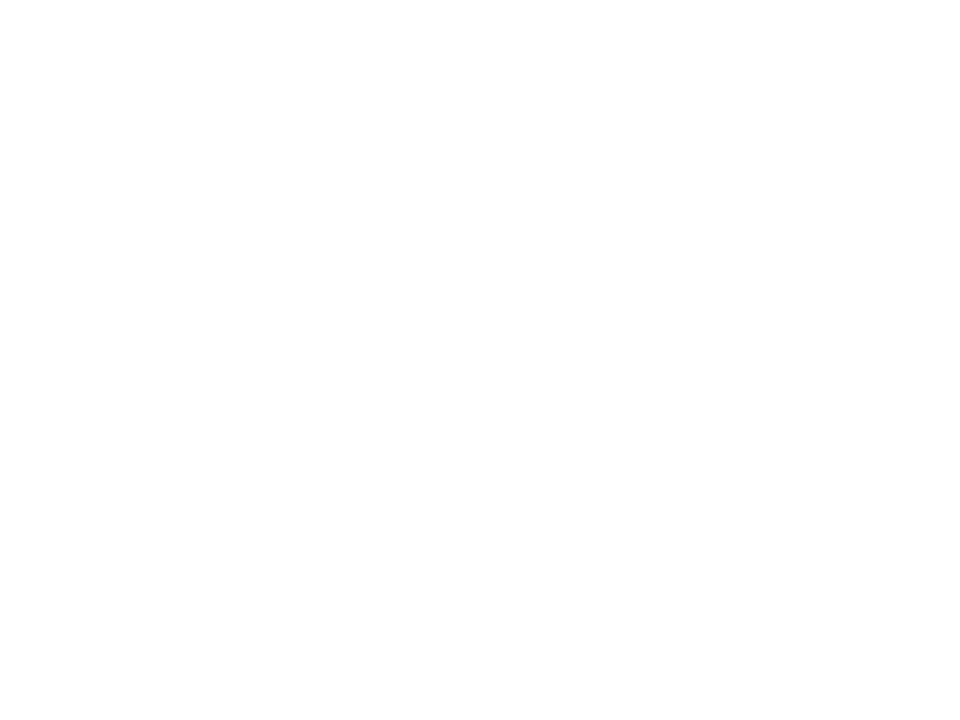

In [37]:
%matplotlib notebook

plt.figure()
# plt.imshow(dFoF_sub_ptile[rmap.isort], aspect='auto', vmax=1)
plt.imshow(
    neural_data_toUse_zscore,
    aspect='auto',
    vmin=-1, 
    vmax=2,
)

In [38]:
# OLS Regression
theta, factors_temporal_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T)
factors_temporal_regression = factors_temporal_regression.T

In [39]:
# # Ridge Regression
# theta, factors_temporal_regression, bias = linear_regression.Ridge(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T, lam=100000)
# factors_temporal_regression = factors_temporal_regression.T

In [40]:
# # ElasticNet Regression
# elr = sklearn.linear_model.ElasticNet(
#     alpha=0.1,
#     l1_ratio=0.05, 
#     fit_intercept=False,
# #     normalize='deprecated',
# #     precompute=False,
#     max_iter=1000, 
# #     copy_X=True, 
#     tol=0.0001,
# #     warm_start=False, 
#     positive=False,
#     random_state=42, 
#     selection='cyclic',
# #     verbose=True,
# )
# elr.fit(neural_data_toUse_zscore.T, factors_temporal_SPCA_zscore.T)

# theta = elr.coef_.T
# factors_temporal_regression = elr.predict(neural_data_toUse_zscore.T).T

<IPython.core.display.Javascript object>


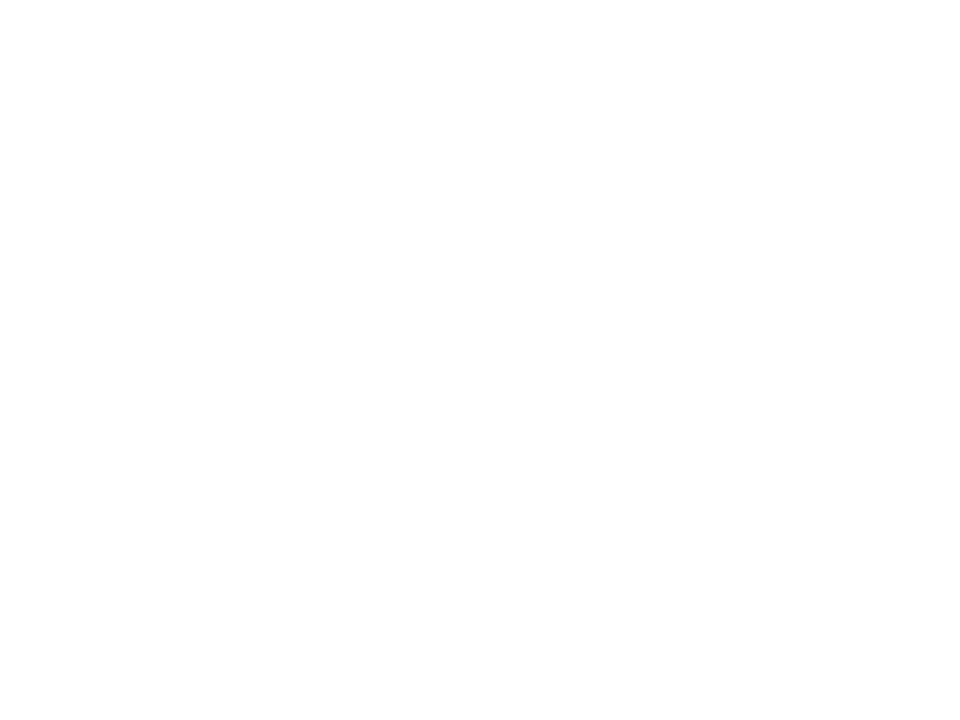

In [41]:
plt.figure()
plt.plot(np.arange(factors_temporal_SPCA_zscore.shape[1])/Fs,  factors_temporal_SPCA_zscore.T + 10*np.arange(rank)[None,:], alpha=0.3);
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_regression.shape[1])/Fs,  factors_temporal_regression.T + 10*np.arange(rank)[None,:]);

In [42]:
similarity.EV(factors_temporal_SPCA_zscore.T, factors_temporal_regression.T)

(array([0.98259715, 0.8479856 , 0.93548959, 0.94809287, 0.82426031,
        0.93960643, 0.89686051, 0.91400757, 0.91124294, 0.91333293]),
 0.9113475901299141,
 0.911347590129914)

In [43]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise, evr_weighted, _ = similarity.pairwise_orthogonalization(factors_temporal_regression.T.astype(np.float32), factors_temporal_SPCA_zscore.T.astype(np.float32))
factors_temporal_tokeep = factors_temporal_regression[pairwise > ev_threshold]

rank_good = (pairwise > ev_threshold).sum()
print(f'Rank above 0.7 EV: {rank_good}')

Rank above 0.7 EV: 10


In [44]:
pairwise

array([0.9827133 , 0.8481723 , 0.93575394, 0.94847226, 0.8249542 ,
       0.93969464, 0.897375  , 0.9141621 , 0.91128016, 0.9134513 ],
      dtype=float32)

In [45]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_ortho[:,indices_to_use].T, factors_temporal_tokeep,  np.ones(rank, bool))

<IPython.core.display.Javascript object>


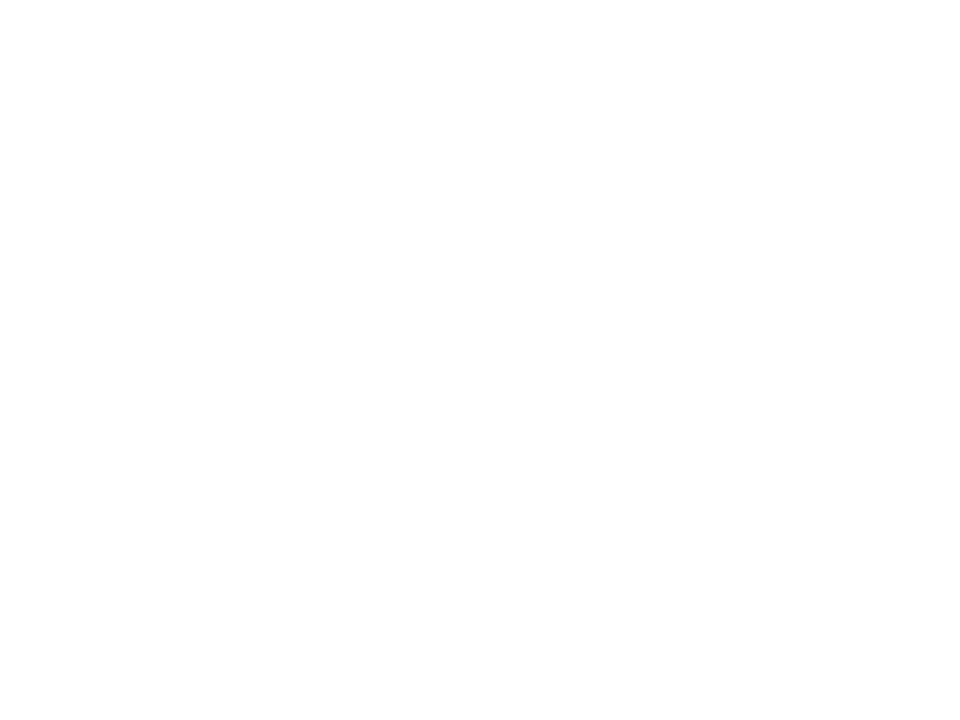

In [46]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_SPCA_zscore[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs,  factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good));

<IPython.core.display.Javascript object>


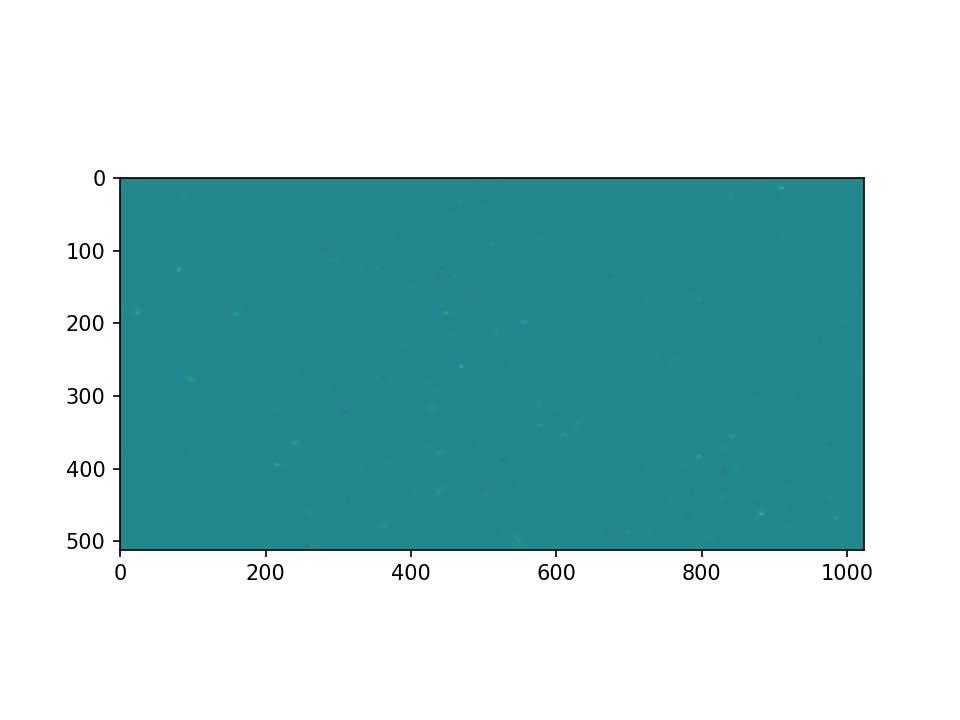

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [47]:
weights = theta[:,np.argsort(evrs)[::-1]]
# weights = theta
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

%matplotlib notebook
display_toggle_image_stack(
    sf_weights, 
    clim=[sf_weights.min(), sf_weights.max()]
)

# Run temporal factor Orthogonalization

In [85]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
num_factors = rank_good
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 0 index explains 0.007827529965860669 of the variance in neural data
Factor at 1 index explains 0.004550923527802175 of the variance in neural data
Factor at 2 index explains 0.004355960482823273 of the variance in neural data
Factor at 3 index explains 0.004063493992131795 of the variance in neural data
Factor at 4 index explains 0.0038908520157538984 of the variance in neural data
Factor at 5 index explains 0.0036876751452344925 of the variance in neural data
Factor at 6 index explains 0.003701965828643461 of the variance in neural data
Factor at 7 index explains 0.003332739932525919 of the variance in neural data
Factor at 8 index explains 0.003285232077471445 of the variance in neural data


<IPython.core.display.Javascript object>


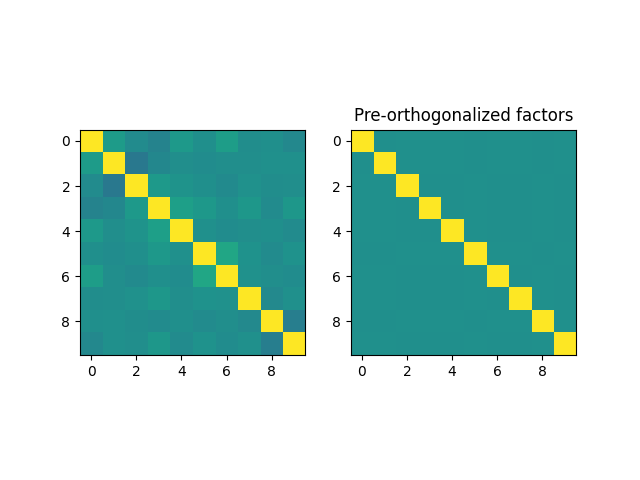

Text(0.5, 1.0, 'Pre-orthogonalized factors')

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)
ax2.set_title("Pre-orthogonalized factors")

In [87]:
_, _, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth,  np.ones(num_factors, bool))

In [88]:
np.sort(evrs)

array([0.003072  , 0.00328523, 0.00333274, 0.00368768, 0.00370197,
       0.00389085, 0.00406349, 0.00435596, 0.00455092, 0.00782753])

# Run Regression Pt 2

In [89]:
# OLS Regression
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [90]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_orth,  np.ones(num_factors, bool))

<IPython.core.display.Javascript object>


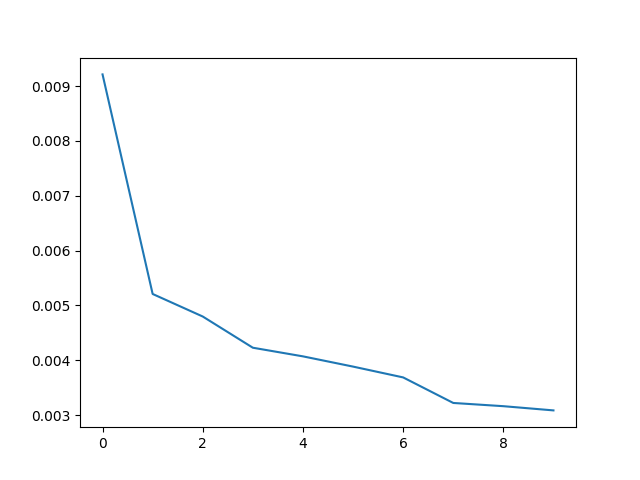

In [116]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

<IPython.core.display.Javascript object>


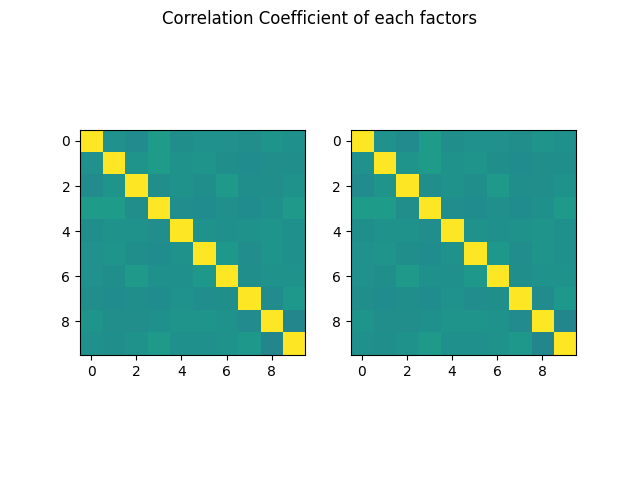

Text(0.5, 0.98, 'Correlation Coefficient of each factors')

In [120]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(theta.T),vmin=-1)
ax2.imshow(np.corrcoef(weights_zeroSum.T),vmin=-1)
f.suptitle("Correlation Coefficient of each factors", verticalalignment='top')

# Visualize

<IPython.core.display.Javascript object>


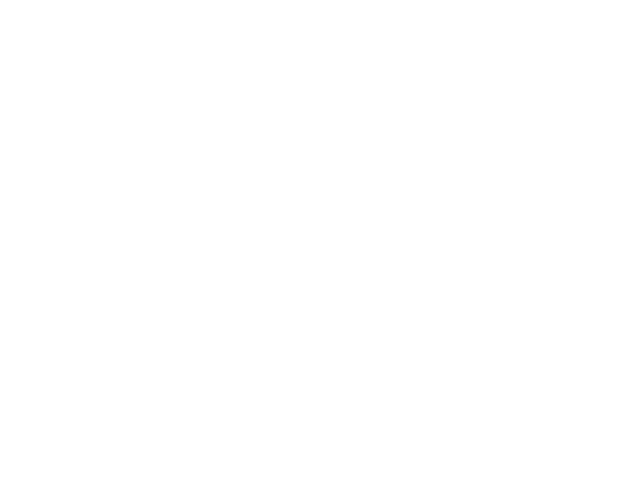

In [92]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

<IPython.core.display.Javascript object>


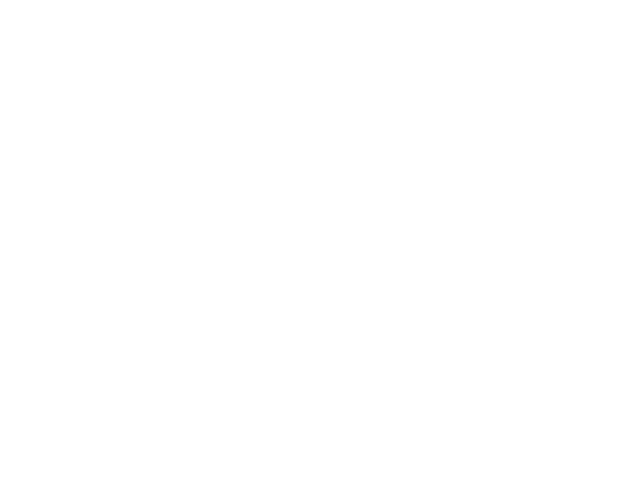

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [93]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

factors_orth_regression_sorted = factors_orth_regression[np.argsort(evrs)[::-1]]

%matplotlib notebook
display_toggle_image_stack(sf_weights)

In [94]:
weights_zeroSum = weights - weights.mean(0)

<IPython.core.display.Javascript object>


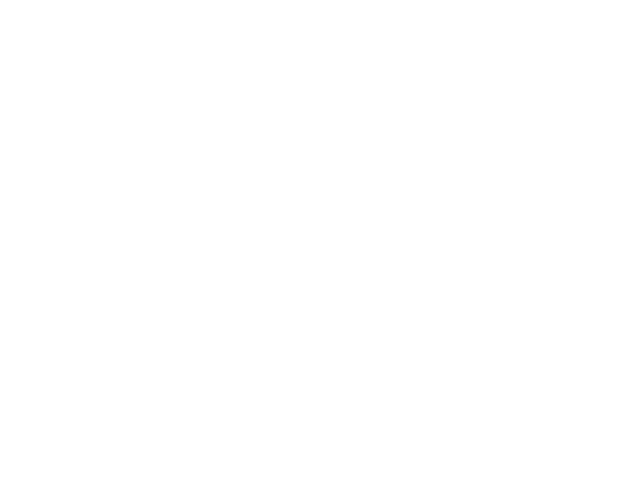

In [95]:
%matplotlib notebook
plt.figure()
plt.imshow(theta[:,:],aspect='auto', interpolation='none')

<IPython.core.display.Javascript object>


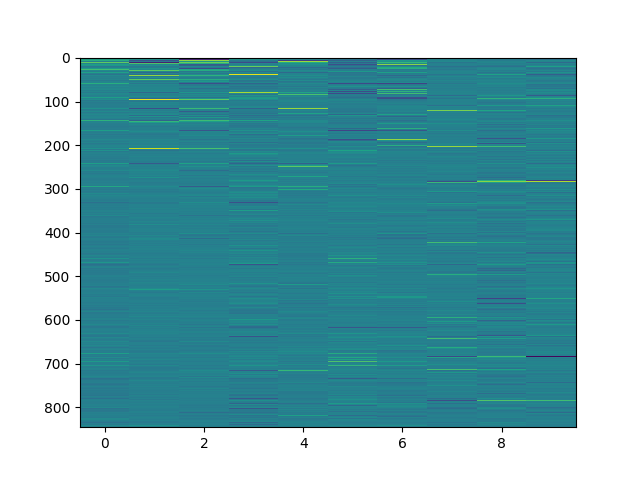

In [96]:
%matplotlib notebook
plt.figure()
plt.imshow(weights_zeroSum[:,:],aspect='auto', interpolation='none')

# Save it all

In [ ]:
factor_to_use = 0 # 0-indexed
weights = theta[:,np.argsort(evrs)[::-1]]

weights_day0 = {
    "weights": weights_zeroSum[:,factor_to_use],
    "weights_all" : weights_zeroSum,
    "factors_neural": weights
    "iscell_custom": iscell,
    "factor_to_use": factor_to_use,
    "sf_weights": sf_weights,
#     "factors_temporal": factors_temporal_tokeep,
    "factors_temporal": factors_orth_regression_sorted,
}


F = scipy.io.savemat(path_save.with_suffix('.mat') , weights_day0)

np.save(path_save.with_suffix('.npy') , weights_day0)

# Load in old outputs

In [48]:
import numpy as np

In [53]:
data = np.load(r'/n/data1/hms/neurobio/sabatini/gyu/data_done/mouse_1511L/20230111/analysis_data/weights_day0.npy', allow_pickle=True)[()]

In [54]:
data.keys()

dict_keys(['weights', 'weights_all', 'iscell_custom', 'factor_to_use', 'sf_weights', 'factors_temporal'])

In [60]:
factor_0_temporal = data['factors_temporal'][2]
factor_2_temporal = data['factors_temporal'][1]

In [61]:
factor_0_temporal.shape

(90000,)

In [62]:
factors_orth.shape

(10, 90000)

In [78]:
factors_orth = copy.deepcopy(factors_temporal_tokeep)
factors_orth = orthogonalize_simple(factors_orth.T, factor_0_temporal[:,None]).T
num_factors = rank_good
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth[hits] = np.transpose(orthogonalize_simple(factors_orth[hits].T, factor_to_orthogonalize))

Factor at 1 index explains 0.0047800450675639095 of the variance in neural data
Factor at 2 index explains 0.004361380525522485 of the variance in neural data
Factor at 3 index explains 0.003958830840740335 of the variance in neural data
Factor at 4 index explains 0.003911812531438685 of the variance in neural data
Factor at 5 index explains 0.003709868201950184 of the variance in neural data
Factor at 6 index explains 0.0037147890864166477 of the variance in neural data
Factor at 7 index explains 0.0033328781289018172 of the variance in neural data
Factor at 8 index explains 0.0032898997365604643 of the variance in neural data
Factor at 9 index explains 0.003074105577962505 of the variance in neural data


<IPython.core.display.Javascript object>


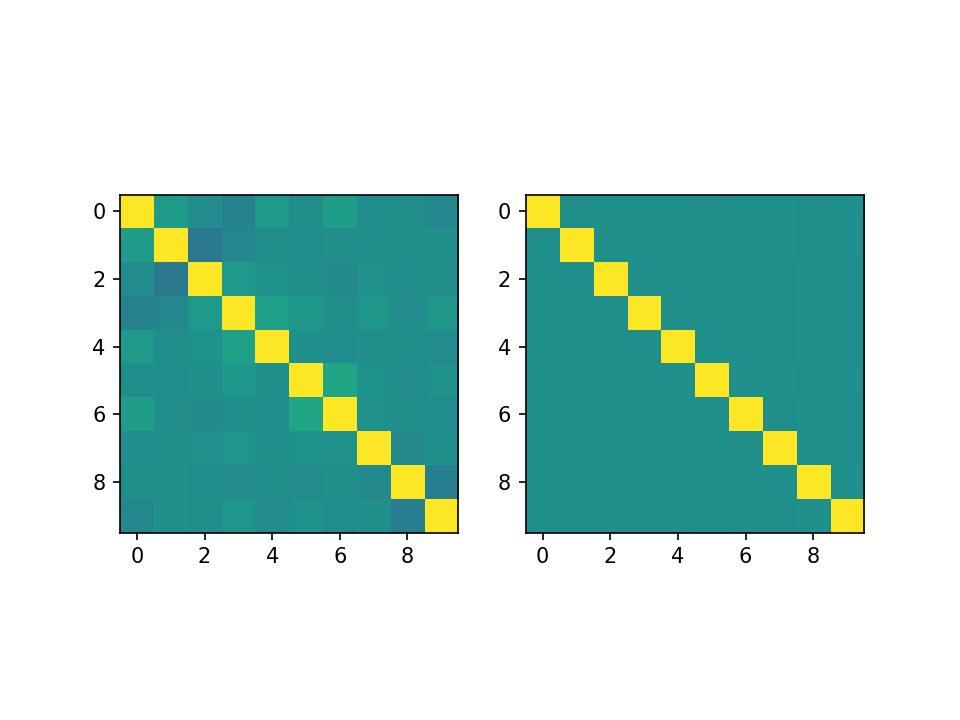

In [79]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(factors_orth),vmin=-1)

In [80]:
# OLS Regression
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, test)
factors_orth_regression = factors_orth_regression.T

In [81]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_orth,  np.ones(num_factors, bool))

In [123]:
evrs

array([0.00921341, 0.00520838, 0.00479707, 0.00422794, 0.00407041,
       0.00388367, 0.00368634, 0.00322051, 0.00316155, 0.00308472])

<IPython.core.display.Javascript object>


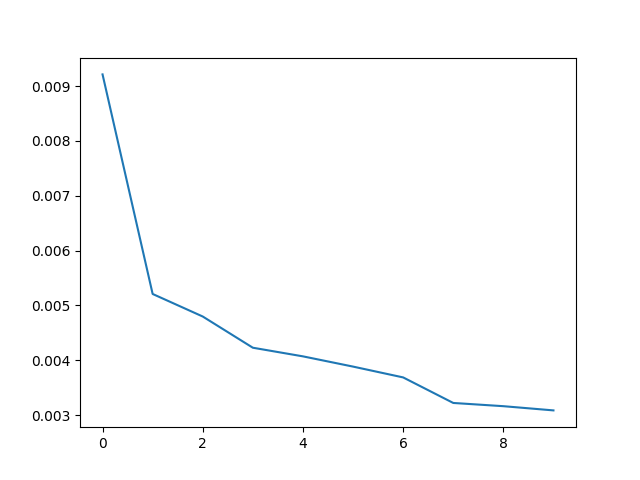

In [122]:
plt.figure()
plt.plot(np.sort(evrs)[::-1])

<IPython.core.display.Javascript object>


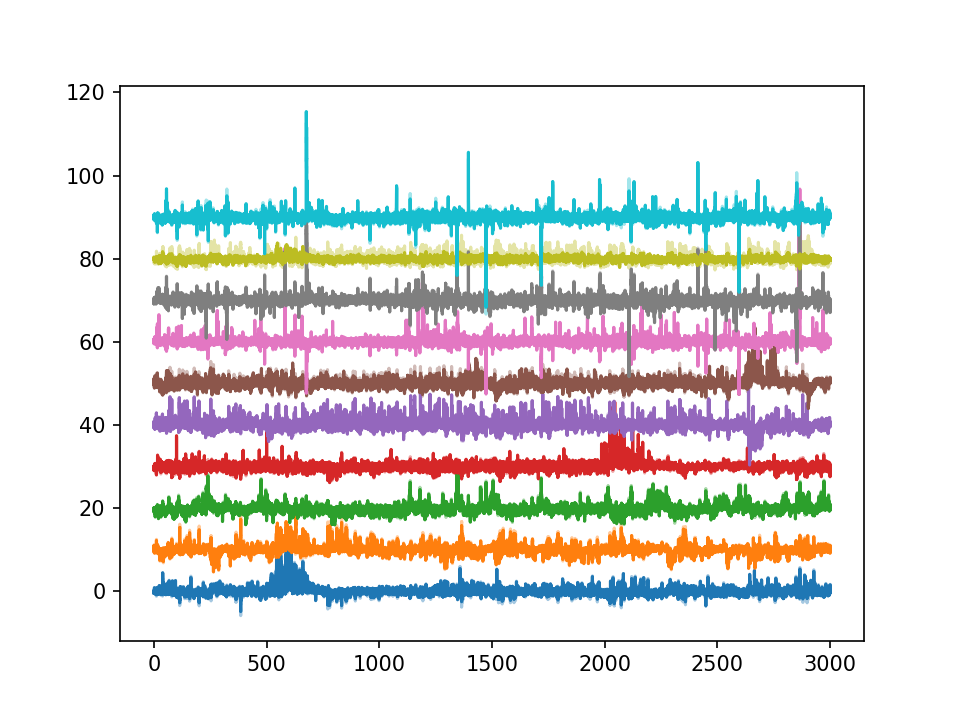

In [83]:
%matplotlib notebook
plt.figure()
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_temporal_tokeep[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good),alpha=0.4)
plt.gca().set_prop_cycle(None)
plt.plot(np.arange(factors_temporal_tokeep.shape[1])/Fs, factors_orth_regression[np.argsort(evrs)[::-1],:].T + 10*np.arange(rank_good))

<IPython.core.display.Javascript object>


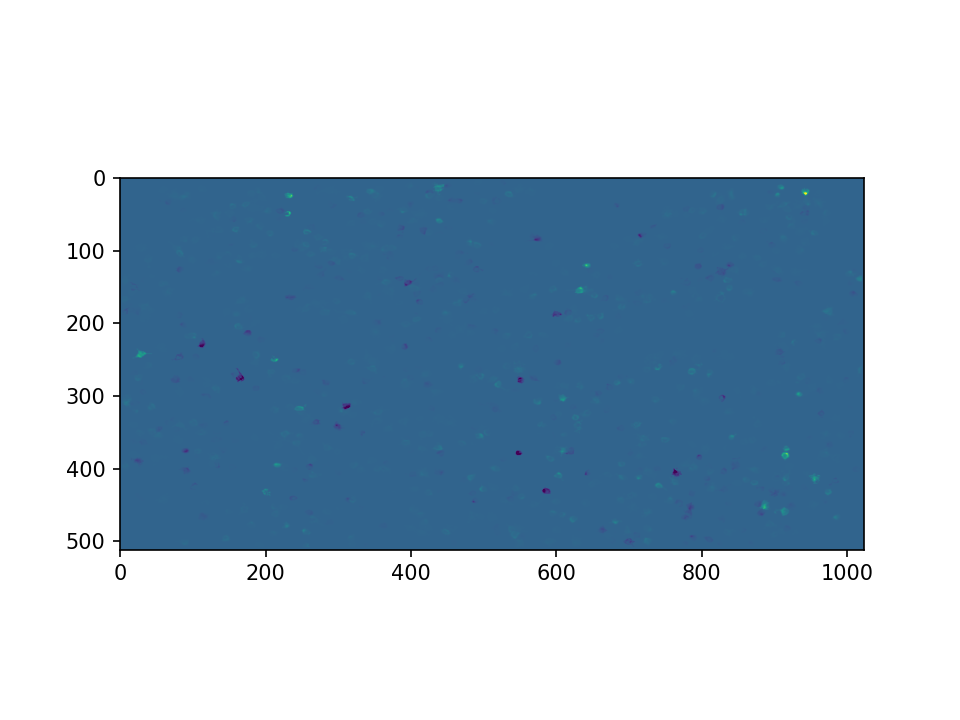

interactive(children=(IntSlider(value=0, description='i_frame', max=9), Output()), _dom_classes=('widget-inter…

In [84]:
weights = theta[:,np.argsort(evrs)[::-1]]
sf_weights = np.einsum('ij,ikl->jkl', weights,sf[iscell])

factors_orth_regression_sorted = factors_orth_regression[np.argsort(evrs)[::-1]]

%matplotlib notebook
display_toggle_image_stack(sf_weights)

In [56]:
import bnpm.plotting_helpers

<IPython.core.display.Javascript object>


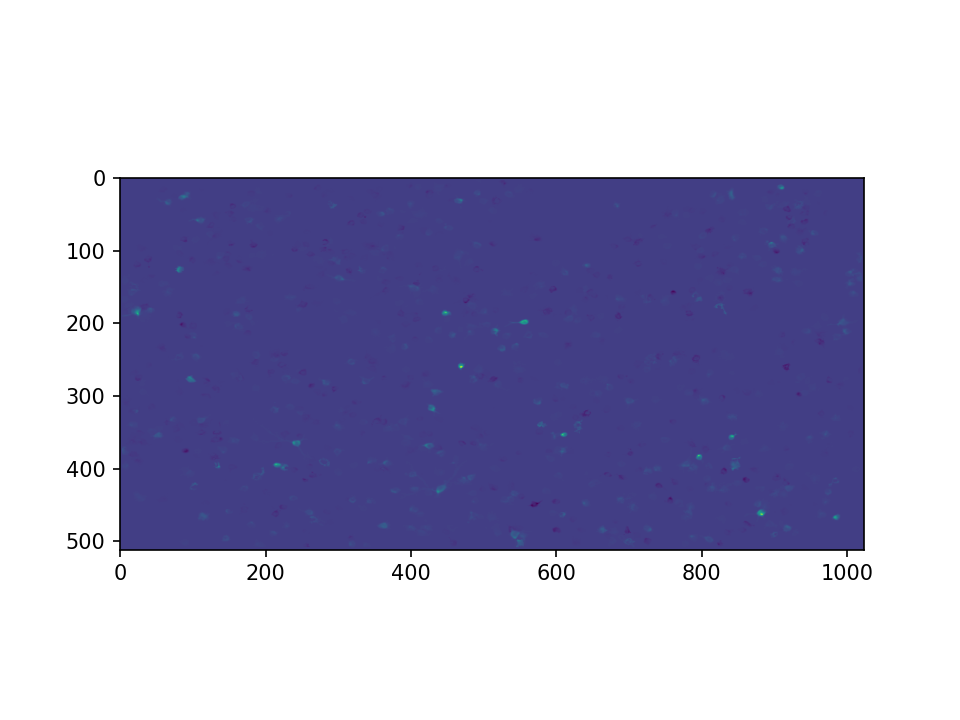

interactive(children=(IntSlider(value=0, description='i_frame', max=5), Output()), _dom_classes=('widget-inter…

In [57]:
# weights = theta[:,np.argsort(evrs)[::-1]]
# sf_weights = np.einsum('ij,ikl->jkl', data['weights_all'], sf[data['iscell_custom']])

%matplotlib notebook
bnpm.plotting_helpers.display_toggle_image_stack(data['sf_weights'])

# Pre-orthogonalize vs. Post-orthogonalize

In [97]:
data['weights_all'].shape

(846, 6)

In [98]:
avgVector.shape

(1, 846)

In [113]:
np.var(data['weights_all'], axis=0)

array([0.0001674 , 0.0002384 , 0.00022759, 0.00034023, 0.00038999,
       0.00020106], dtype=float32)

In [109]:
test = orthogonalize_simple(data['weights_all'], avgVector.T)

In [110]:
test.shape

(846, 6)

In [111]:
test.mean(0)

array([-3.87442081e-18,  2.05870256e-18,  6.94350753e-18,  1.44765340e-18,
       -1.21225593e-17,  9.13446738e-18])

In [112]:
np.var(test, axis=0)

array([0.0001674 , 0.0002384 , 0.00022759, 0.00034023, 0.00038999,
       0.00020106])

<IPython.core.display.Javascript object>


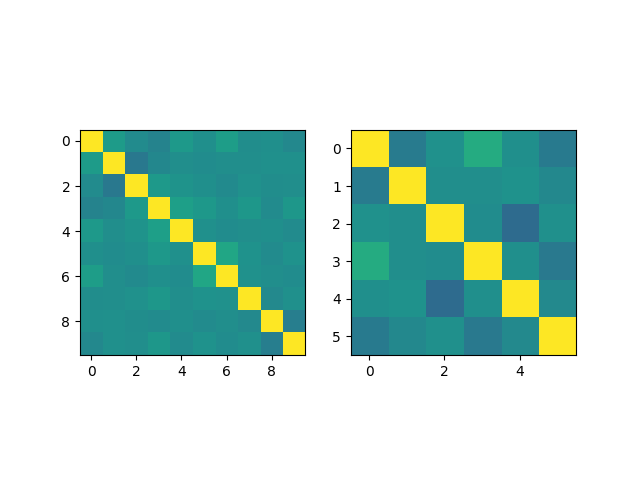

In [115]:
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.corrcoef(factors_temporal_tokeep),vmin=-1)
ax2.imshow(np.corrcoef(test.T),vmin=-1)

In [126]:
# Initialization method: np.linalg.svd(X, full_matrices=False)
SPCA2 = sklearn.decomposition.SparsePCA(n_components=rank,
                                             alpha=1,
                                             ridge_alpha=0.01,
                                             max_iter=100,
                                             tol=1e-08,
                                             method='lars',
                                             n_jobs=-1,
                                             U_init=None,
                                             V_init=None,
                                             verbose=True,
                                             random_state=None)

factors_SPCA2 = SPCA2.fit_transform(neural_data_toUse_ms.T)

[dict_learning] .

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    2.0s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.7s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.6s finished


In [129]:
factors_neuron_SPCA2 = SPCA.components_.T
factors_temporal_SPCA2 = factors_SPCA2.T

# Run Regression

In [130]:
indices_to_use = np.arange(int(Fs*60*10),neural_data_toUse.shape[1])

## z-score SPCA  temporal factors
factors_temporal_SPCA2_zscore = scipy.stats.zscore(factors_temporal_SPCA2[:,indices_to_use],axis=1)

In [131]:
# OLS Regression
theta2, factors_temporal_regression2, bias2 = linear_regression.OLS(neural_data_toUse_zscore.T, factors_temporal_SPCA2_zscore.T)
factors_temporal_regression2 = factors_temporal_regression2.T

In [133]:
# Filter based on Explained Variance
# If we can't predict a factor well, don't keep it
ev_threshold = 0.7
_, pairwise2, evr_weighted2, _ = similarity.pairwise_orthogonalization(factors_temporal_regression2.T.astype(np.float32), factors_temporal_SPCA2_zscore.T.astype(np.float32))
factors_temporal_tokeep2 = factors_temporal_regression2[pairwise2 > ev_threshold]

rank_good = (pairwise2 > ev_threshold).sum()
print(f'Rank above 0.7 EV: {rank_good}')

Rank above 0.7 EV: 10


In [134]:
pairwise2

array([0.9720609 , 0.7528547 , 0.80866414, 0.93624115, 0.7732543 ,
       0.8085451 , 0.88713616, 0.9391492 , 0.874696  , 0.8631441 ],
      dtype=float32)

In [135]:
_, _, evrs2 = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_temporal_tokeep2,  np.ones(rank, bool))

# Run temporal factor Orthogonalization

In [136]:
factors_orth2 = copy.deepcopy(factors_temporal_tokeep2)
num_factors = rank_good
hits = np.ones(num_factors, bool)
for i in range(num_factors-1):
    ind_to_orthogonalize, factor_to_orthogonalize, evrs = get_highest_evr_var(neural_data_toUse_zscore.T, factors_orth2, hits)
    print(f'Factor at {ind_to_orthogonalize} index explains {evrs[ind_to_orthogonalize]} of the variance in neural data')
    hits[ind_to_orthogonalize] = False
    factors_orth2[hits] = np.transpose(orthogonalize_simple(factors_orth2[hits].T, factor_to_orthogonalize))

Factor at 0 index explains 0.00761669054581815 of the variance in neural data
Factor at 2 index explains 0.004417438749334535 of the variance in neural data
Factor at 3 index explains 0.004309391958960296 of the variance in neural data
Factor at 6 index explains 0.004104564543454203 of the variance in neural data
Factor at 1 index explains 0.003717982112777962 of the variance in neural data
Factor at 4 index explains 0.0036064538423544734 of the variance in neural data
Factor at 7 index explains 0.003374091778811983 of the variance in neural data
Factor at 5 index explains 0.003304833316081335 of the variance in neural data
Factor at 8 index explains 0.00324067659659677 of the variance in neural data


In [137]:
avgVector = np.ones([846,1])

In [138]:
vector_to_orthogonalize = (neural_data_toUse_zscore.T @ avgVector) / (avgVector.T @ avgVector)

In [ ]:
test = orthogonalize_simple(factors_orth2.T, vector_to_orthogonalize)

In [ ]:
test.shape

In [87]:
_, _, evrs2 = get_highest_evr_var(neural_data_toUse_zscore.T, test,  np.ones(num_factors, bool))

In [88]:
np.sort(evrs2)

array([0.003072  , 0.00328523, 0.00333274, 0.00368768, 0.00370197,
       0.00389085, 0.00406349, 0.00435596, 0.00455092, 0.00782753])

# Run Regression Pt 2

In [89]:
# OLS Regression
theta, factors_orth_regression, bias = linear_regression.OLS(neural_data_toUse_zscore.T, factors_orth.T)
factors_orth_regression = factors_orth_regression.T

In [90]:
_, _, evrs = get_highest_evr_var(neural_data_toUse[:,indices_to_use].T, factors_orth,  np.ones(num_factors, bool))